In [102]:
import matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy.stats as stats, pandas as pd, os, glob
import ast
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## make any changes required to files from older version of expt and save as new file

In [ ]:
# for subj in ['tomas', 'Zelin', 'renee', 'robert', 'daria']:
#     # read in csv, change col name from target to target_pos, write it back
#     df = pd.read_csv(glob.glob(f'../results/*asymmetry*{subj}*csv')[0])
#     df.rename(columns={'target': 'target_pos'}, inplace=True)
#     df.rename(columns={'context': 'valence'}, inplace=True)
#     df.rename(columns={'divider': 'div'}, inplace=True)
#     df.rename(columns={'disp_divider': 'disp_div'}, inplace=True)

#     # if trials.slider_resp.keys == None or trials.submit_resp.keys == None, then trials.correct = 0 and trials.outcome = 0
#     df.loc[df['slider_resp.keys'].isna() | df['trials.submit_resp.keys'].isna(), ['correct', 'outcome']] = 0

#     df.to_csv(f'../results/arch/formatted/{subj}.csv', index=False)

## load df and check

In [103]:
subjs = ['tomas', 'Zelin', 'renee', 'robert', 'daria', 'salma']
subjs_anon = ['a_v2', 'b_v2', 'c_v2', 'd', 'e', 'f']

df = pd.read_csv(glob.glob(f'../results/formatted/{subjs[0]}*csv')[0])#[:-1]
for subj in subjs[1:]:
    df_temp = pd.read_csv(glob.glob(f'../results/formatted/{subj}*csv')[0])#[:-1]#[1:]
    df = pd.concat([df, df_temp], ignore_index=True)

print(f'df_len = {len(df)} = {240*4 + 300*2}')
# df.to_csv(f'../results/formatted/combined_results.csv', index=False)

df_len = 1560 = 1560


## filtering df

In [104]:
# 1.
print(df['correct'].value_counts(normalize=True))

# 2.
for col in ['positions']:
    if type(df[col][0]) == str:
        df[col] = df[col].apply(lambda x: ast.literal_eval(x)) # convert str to list

# 3. # get dist between targer & last position
df['MAE_unnormed'] = abs(df['target_pos'] - df['positions'].apply(lambda x: x[-1]))
df['MAE_normed'] = np.where(
    ((df['div'] == -0.2) & (df['valence'] == 'pen')) | ((df['div'] == 0.2) & (df['valence'] == 'rew')),
    df['MAE_unnormed']*2, 
    df['MAE_unnormed']
)
# 4.
df['dist'] = df['positions'].apply(lambda x: abs(x[-1] - x[0]))
df['avg_speed'] = df['dist'] / df['trials.submit_resp.rt']

# 5.
df['choice'] = df['outcome'].apply(lambda x: 1 if abs(x) == 2 else 0 if abs(x) == 1 else 0)
# df = df[df['choice'] != 0]

# 6.
# filtering out easy trials
df_hard = df[df['target_pos'] - df['disp_div'] <= .05].copy()
print(f'% trials with |target-divider| <= .1: {len(df_hard)/len(df)}')

correct
 1.0    0.810897
-1.0    0.181410
 0.0    0.007692
Name: proportion, dtype: float64
% trials with |target-divider| <= .1: 0.5865384615384616


## accuracy & RT by valence and compression

compression
baseline              520
penalty compressed    520
reward compressed     520
Name: count, dtype: int64
correct
1.0    1265
0.0     295
Name: count, dtype: int64


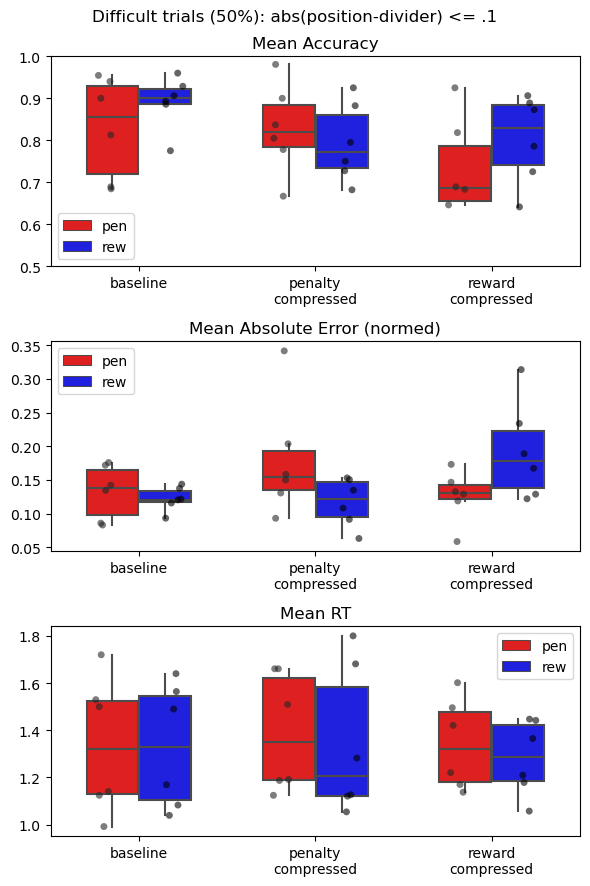

In [108]:
# df_plot = df_hard.copy()
df_plot = df.copy()

df_plot['compression'] = df_plot['div'].apply(lambda x: 'baseline' if x == 0 else 'penalty compressed' if x == -.2 else 'reward compressed')
df_plot['correct'] = df_plot['correct'].apply(lambda x: 0 if x == -1 else x)
print(df_plot['compression'].value_counts())
print(df_plot['correct'].value_counts())

fig, axes = plt.subplots(3, 1, figsize=(6, 9))
fig.suptitle('Difficult trials (50%): abs(position-divider) <= .1')

# 1.
ax = axes[0]
group_df = df_plot.groupby(['subj', 'compression', 'valence'])['correct'].mean().reset_index()
sns.boxplot(data=group_df, x='compression', y='correct', hue='valence',
            showcaps=False, fliersize=0, width=0.6, palette = {'rew': 'blue', 'pen': 'red'}, ax=ax)
sns.stripplot(data=group_df, x='compression', y='correct', hue='valence', 
              dodge=True, color='black', alpha=0.6, jitter=True, legend=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(.5, 1)
ax.set_title('Mean Accuracy')
ax.legend()
ax.set_xticklabels(['baseline', 'penalty\ncompressed', 'reward\ncompressed'])

# 2.
ax = axes[1]
group_df = df_plot.groupby(['subj', 'compression', 'valence'])['MAE_normed'].mean().reset_index()
sns.boxplot(data=group_df, x='compression', y='MAE_normed', hue='valence',
            showcaps=False, fliersize=0, width=0.6, palette = {'rew': 'blue', 'pen': 'red'}, ax=ax)
sns.stripplot(data=group_df, x='compression', y='MAE_normed', hue='valence', 
              dodge=True, color='black', alpha=0.6, jitter=True, legend=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean Absolute Error (normed)')
ax.legend()
ax.set_xticklabels(['baseline', 'penalty\ncompressed', 'reward\ncompressed'])

# 3.
ax = axes[2]
group_df = df_plot.groupby(['subj', 'compression', 'valence'])['trials.submit_resp.rt'].mean().reset_index()
sns.boxplot(data=group_df, x='compression', y='trials.submit_resp.rt', hue='valence',
            showcaps=False, fliersize=0, width=0.6, palette = {'rew': 'blue', 'pen': 'red'}, ax=ax)
sns.stripplot(data=group_df, x='compression', y='trials.submit_resp.rt', hue='valence', 
              dodge=True, color='black', alpha=0.6, jitter=True, legend=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean RT')
ax.legend()
ax.set_xticklabels(['baseline', 'penalty\ncompressed', 'reward\ncompressed'])


plt.tight_layout()
plt.show()

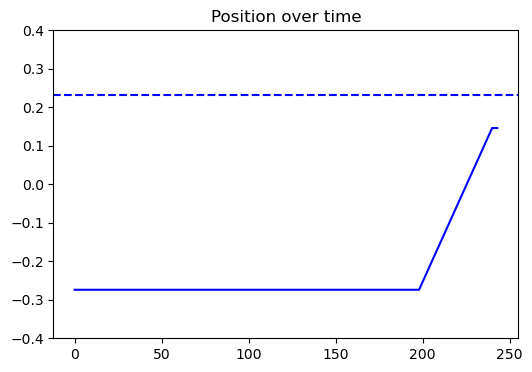

In [82]:
# plot position over time
plt.figure(figsize=(6, 4))

plt.plot(df['positions'].iloc[10], color='blue')
plt.ylim(-.4, .4)
plt.axhline(y=df['target'].iloc[10], color='blue', linestyle='--')
plt.title('Position over time')
plt.show()

## psychometric curves

In [78]:
from scipy.optimize import curve_fit

# Define sigmoid function
def sigmoid(x, x0, k):
    return 1 / (1 + np.exp(-k * (x - x0)))

# Convert choice to numeric (1 for risky, 0 for safe)
df_choice['choice_numeric'] = df_choice['choice'].map({'risky': 1, 'safe': 0})

# Initialize plot
plt.figure(figsize=(8, 6))

# Get unique subjects
subjects = df_choice['subj'].unique()

# Define color palette for subjects
palette = sns.color_palette("husl", len(subjects))

# Loop through each subject
for i, subj in enumerate(subjects):
    # Compute mean risky choice probability at each stim_pos for the subject
    grouped = df_choice[df_choice['subj'] == subj].groupby('stim_pos')['choice'].mean().reset_index()

    # Fit sigmoid function
    popt, _ = curve_fit(sigmoid, grouped['stim_pos'], grouped['choice'])
    
    # Generate smooth x values for curve
    x_vals = np.linspace(grouped['stim_pos'].min(), grouped['stim_pos'].max(), 100)
    y_vals = sigmoid(x_vals, *popt)

    # Plot fitted sigmoid curve
    plt.plot(x_vals, y_vals, color=palette[i], linestyle='-', label=f'Subj {subj}')

    # Scatter plot for observed probabilities
    sns.scatterplot(data=grouped, x='stim_pos', y='choice', color=palette[i], edgecolor='black')

# Labels and legend
plt.xlabel('Stimulus Position')
plt.ylabel('P(Risky Choice)')
plt.title('Psychometric Curves by Subject')
plt.legend()
plt.show()


NameError: name 'df_choice' is not defined